# Day 07 - graph solving

- [Day 7](https://adventofcode.com/2018/day/7)

We are asked to order the nodes of a dependency graph here, so we need to implement a [topological sort](https://en.wikipedia.org/wiki/Topological_sorting), but with a small twist: nodes in the graph that have become available (all dependencies have been satisfied) must be visited in alphabetical order. This makes it a _priority_ ordering, really.

We start with putting the nodes and edges into a dictionary; `{node: {dep, dep, ...}}`, where keys are dependencies for the nodes in the value set. We can then use Kahn's algorithm to visit all the nodes in order.

1. We track incoming edges by reversing the graph dictionary: `{dep: {node, node, ...}}`.
2. Every time we process a node, we remove it from the outgoing edges (`edges[dep].remove(node)`). If there are no more edges for the node then we can queue it up.

Note that we have to visit available nodes in _sorted_ order; we can use a [`heapq`](https://docs.python.org/3/library/heapq.html) to maintain the queue of available nodes to visit, this will efficiently keep nodes we add in an order that'll give us the next available letter in their alphabetical sorting order.


In [1]:
import re
from heapq import heapify, heappop, heappush

_parse_line = re.compile(
    r"Step (?P<dep>[A-Z]+) must be finished before step (?P<node>[A-Z]+) can begin."
)


def parse_graph(t):
    graph = {}
    for dep, node in _parse_line.findall(t):
        graph.setdefault(dep, set()).add(node)
    return graph


def topological_sort(graph):
    edges = {}
    for node, deps in graph.items():
        for d in deps:
            edges.setdefault(d, set()).add(node)
    # determine what nodes have no incoming edges
    # this is a set operation: any key in graph that's not a key in edges
    start = graph.keys() - edges
    # set up our queue, ensuring we process the next best node (alphabetical order)
    queue = list(start)
    heapify(queue)
    while queue:
        node = heappop(queue)
        yield node
        for dep in graph.get(node, ()):
            edges[dep].remove(node)
            # only when there are more outgoing edges left
            if not edges[dep]:
                heappush(queue, dep)

In [2]:
testgraph = parse_graph(
    """
Step C must be finished before step A can begin.
Step C must be finished before step F can begin.
Step A must be finished before step B can begin.
Step A must be finished before step D can begin.
Step B must be finished before step E can begin.
Step D must be finished before step E can begin.
Step F must be finished before step E can begin."""
)
assert "".join(topological_sort(testgraph)) == "CABDFE"

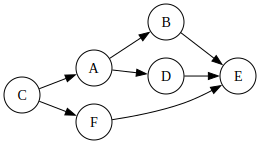

In [3]:
import subprocess

import graphviz


def plot_graph(g, **graph_attr):
    dot = graphviz.Digraph("sled_instructions", strict=True)
    dot.attr(**graph_attr)
    dot.attr("node", shape="circle")
    with dot.subgraph(graph_attr={"rank": "min"}) as startnodes:
        for node in set(g) - set().union(*g.values()):
            startnodes.node(node)
    with dot.subgraph(graph_attr={"rank": "max"}) as endnodes:
        for node in set().union(*g.values()) - set(g):
            endnodes.node(node)
    for dep, nodes in sorted(g.items()):
        dot.edges((dep, n) for n in nodes)

    try:
        # attempt to process the graph through tred, if available
        result = subprocess.run(
            "tred", input=dot.source, capture_output=True, encoding="utf8"
        )
        if result.returncode == 0:
            dot = graphviz.Source(result.stdout)
    except OSError:
        pass

    return dot


plot_graph(testgraph, rankdir="LR")

In [4]:
import aocd

data = aocd.get_data(day=7, year=2018)
graph = parse_graph(data)

In [5]:
print("Part 1:", "".join(topological_sort(graph)))

Part 1: GDHOSUXACIMRTPWNYJLEQFVZBK


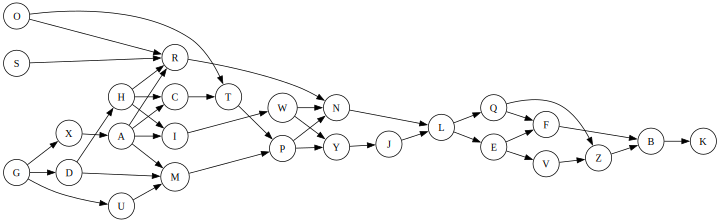

In [6]:
plot_graph(graph, rankdir="LR", size="10,6")

# Part 2

This part introduces a second priority queue: one to manage the jobs being processed, and this queue has a limited size. We still keep the original priority queue to manage graph traversal, as the 'todo'.

The worker priority queue stores the completion time, so `time + duration`, as the priority for jobs. `time` is simply updated by popping the next completed job of the worker queue, at which point we can update the `todo` queue with any now-available nodes. And whenever there is space on the worker queue, we can take items from the todo queue.


In [7]:
from string import ascii_uppercase

testcosts = {lc: i for i, lc in enumerate(ascii_uppercase, 1)}
costs = {uc: i for i, uc in enumerate(ascii_uppercase, 61)}


def execute_steps(graph, worker_count, stepcost=costs):
    edges = {}
    for node, deps in graph.items():
        for d in deps:
            edges.setdefault(d, set()).add(node)
    start = graph.keys() - edges

    todo = list(start)
    heapify(todo)

    workers = []

    time = 0

    while todo or workers:
        # move items from todo to workers
        while todo and len(workers) < worker_count:
            node = heappop(todo)
            complete_at = time + stepcost[node]
            heappush(workers, (complete_at, node))

        assert workers

        # complete a work item and update time
        time, node = heappop(workers)

        for dep in graph.get(node, ()):
            edges[dep].remove(node)
            # only when there are more outgoing edges left
            if not edges[dep]:
                heappush(todo, dep)

    return time

In [8]:
assert execute_steps(testgraph, 2, stepcost=testcosts)

In [9]:
print("Part 2:", execute_steps(graph, 5))

Part 2: 1024


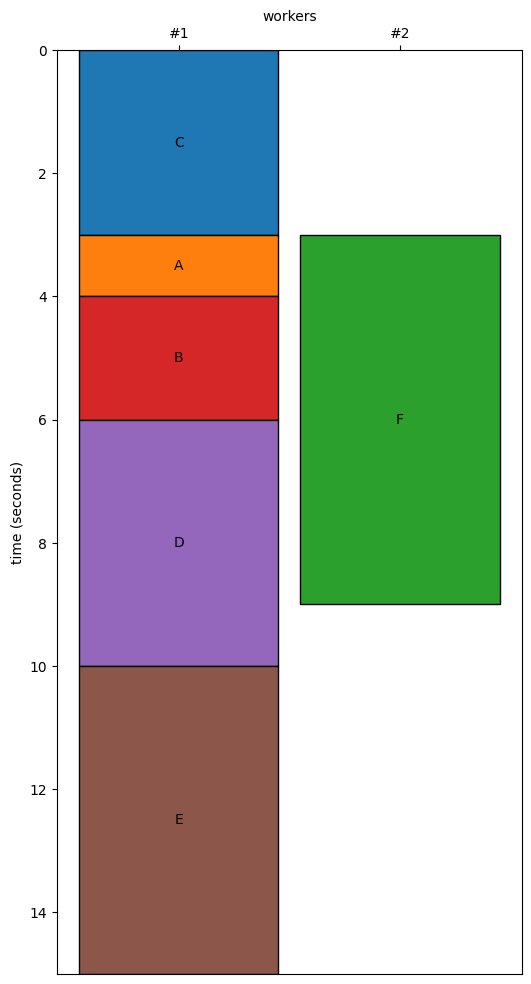

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np


def plot_execution(graph, worker_count, stepcost=costs):
    """Plot worker utilisation as a vertical Gantt chart"""
    _, ax = plt.subplots(figsize=(6, 12))
    # workers go from left to right along x, centered on xaxis[worker + 1]
    xaxis = np.linspace(1, worker_count + 1, worker_count + 1)
    ax.set_xlabel("workers")
    ax.set_xticks(xaxis)
    ax.set_xticklabels([f"#{i + 1}" for i in range(xaxis.size)])
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position("top")
    ax.set_ylabel("time (seconds)")
    data = [[] for _ in range(worker_count)]

    edges = {}
    for node, deps in graph.items():
        for d in deps:
            edges.setdefault(d, set()).add(node)
    start = graph.keys() - edges

    todo = list(start)
    heapify(todo)

    workers = []
    worker_busy = [False] * worker_count

    time = 0

    while todo or workers:
        # move items from todo to workers
        while todo and len(workers) < worker_count:
            node = heappop(todo)
            complete_at = time + stepcost[node]
            worker_id = worker_busy.index(False)
            worker_busy[worker_id] = True
            data[worker_id].append((node, time, complete_at))
            heappush(workers, (complete_at, node, worker_id))

            # add this job to the plot
            ax.bar(
                x=worker_id + 1,
                height=stepcost[node],
                bottom=time,
                width=0.9,
                linewidth=1,
                edgecolor="black",
                align="center",
            )
            ax.text(
                worker_id + 1,
                time + (stepcost[node] / 2),
                node,
                horizontalalignment="center",
                verticalalignment="center",
            )

        # complete a work item and update time
        time, node, worker_id = heappop(workers)
        worker_busy[worker_id] = False

        for dep in graph.get(node, ()):
            edges[dep].remove(node)
            # only when there are more outgoing edges left
            if not edges[dep]:
                heappush(todo, dep)

    ax.set_xlim(left=0.45, right=worker_count + 0.55)
    ax.set_ylim(top=0, bottom=time)
    plt.show()


plot_execution(testgraph, 2, stepcost=testcosts)

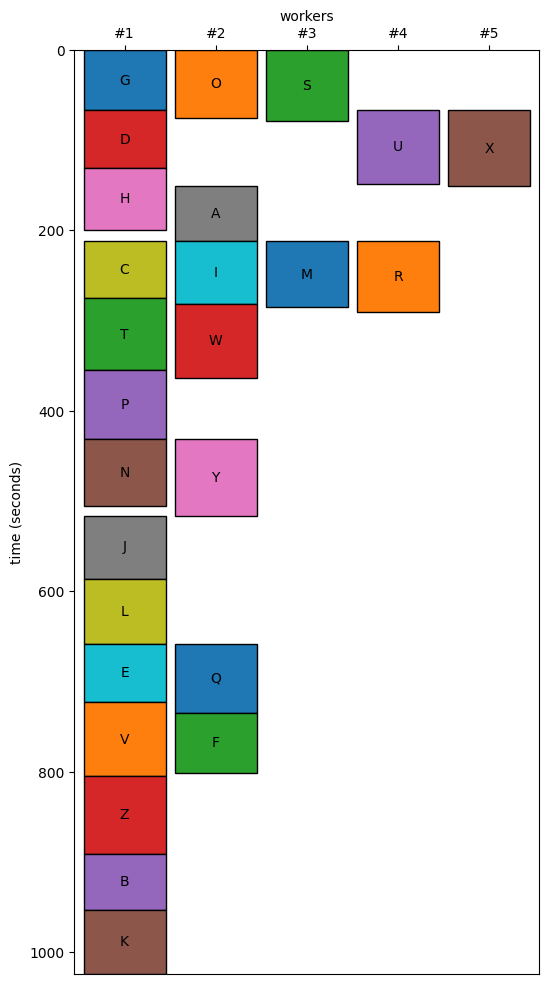

In [11]:
plot_execution(graph, 5)